In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import folium 
import seaborn as sns
import osmnx as ox
import networkx as nx
import pyproj
import math 
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import pysal 
from pysal import esda
#import libpysal #added
pd.options.mode.chained_assignment = None 
#from pysal.explore import esda
from pyproj import CRS
from pyproj import Transformer
from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

/opt/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [68]:
#Hamburg Bounding box
bbox = BboxSelector([
    9.918594360351562, # min_x
    53.50315910192688, # min_y
    10.110855102539062, # max_x
    53.59291234778207  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=100) # requesting 50 tracks inside the bbox
#display output
track_df

,id,time,geometry,GPS Accuracy.value,GPS Accuracy.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,GPS Speed.value,GPS Speed.unit,GPS Altitude.value,...,O2 Lambda Current ER.value,O2 Lambda Current ER.unit,O2 Lambda Current.value,O2 Lambda Current.unit,track.appVersion,track.touVersion,Long-Term Fuel Trim 1.value,Long-Term Fuel Trim 1.unit,Short-Term Fuel Trim 1.value,Short-Term Fuel Trim 1.unit
0,5cdcea6d44ea85030283f9df,2019-04-15T07:57:44,POINT (7.62735 51.80645),2.3,%,0.336020,ratio,134.906554,km/h,63.912372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5cdcea6d44ea85030283f9e1,2019-04-15T07:57:49,POINT (7.62600 51.80786),2.2,%,0.138903,ratio,130.448702,km/h,65.513918,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5cdcea6d44ea85030283f9e2,2019-04-15T07:57:54,POINT (7.62462 51.80922),2.1,%,0.090592,ratio,132.323921,km/h,66.223409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5cdcea6d44ea85030283f9e3,2019-04-15T07:57:59,POINT (7.62314 51.81063),2.0,%,0.132368,ratio,133.438745,km/h,66.612251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5cdcea6d44ea85030283f9e4,2019-04-15T07:58:04,POINT (7.62164 51.81202),2.0,%,0.162579,ratio,132.869762,km/h,67.179196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,53f20f74e4b0d0547747de5d,2014-06-08T16:05:57,POINT (9.28521 53.19534),4.0,%,NaN,NaN,44.100000,km/h,65.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,7.03125,%,2.34375,%
1127,53f20f74e4b0d0547747de5f,2014-06-08T16:06:03,POINT (9.28605 53.19585),8.0,%,NaN,NaN,47.700000,km/h,67.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,10.15625,%,5.46875,%
1128,53f20f74e4b0d0547747de61,2014-06-08T16:06:09,POINT (9.28683 53.19621),5.0,%,NaN,NaN,31.500000,km/h,69.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.37500,%,7.03125,%
1129,53f20f74e4b0d0547747de63,2014-06-08T16:06:15,POINT (9.28731 53.19595),5.0,%,NaN,NaN,30.600000,km/h,68.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,4.68750,%,2.34375,%


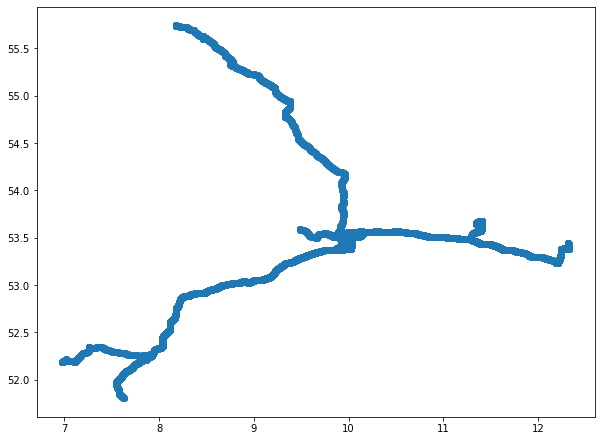

In [69]:
#Track plot
track_df.plot(figsize=(10, 12))

In [70]:
#dataframe details
track_df.describe()

,GPS Accuracy.value,O2 Lambda Voltage ER.value,GPS Speed.value,GPS Altitude.value,Engine Load.value,GPS Bearing.value,Speed.value,Intake Pressure.value,Intake Temperature.value,Throttle Position.value,...,track.length,sensor.engineDisplacement,sensor.constructionYear,Consumption.value,Calculated MAF.value,CO2.value,O2 Lambda Current ER.value,O2 Lambda Current.value,Long-Term Fuel Trim 1.value,Short-Term Fuel Trim 1.value
count,27372.000000,2043.000000,27372.000000,27372.000000,9320.000000,26648.000000,25008.000000,25008.000000,24966.000000,9320.000000,...,27372.000000,27372.000000,27372.000000,6263.000000,21949.000000,6263.000000,1015.000000,1015.000000,5772.000000,5772.000000
mean,6.768645,0.340696,101.053389,77.614779,40.672293,175.627977,102.546225,75.770110,89.796913,47.679715,...,170.036993,1770.166484,2010.543073,10.891273,19.697738,25.594492,1.663868,-7.257891,-0.452075,0.208036
std,3.851232,0.559808,37.880169,31.715651,25.723145,103.954156,36.624245,40.933209,66.655859,29.958889,...,201.375507,367.192439,4.111629,7.362146,13.319433,17.301044,0.324491,67.313416,6.011252,2.623296
min,1.500000,0.059025,-308.447929,-24.651999,0.000000,-370.999985,0.000000,10.000000,1.000000,5.000000,...,0.000000,1598.000000,2003.000000,0.834954,0.000000,1.962142,0.985220,-127.662640,-13.281250,-14.062500
25%,3.000000,0.097378,83.091004,62.000000,18.431372,79.000000,85.000000,45.000000,15.000000,24.000000,...,0.000000,1600.000000,2011.000000,4.769779,10.912204,11.208980,1.432639,-64.083505,-4.687500,-1.562500
50%,5.000000,0.112489,112.500000,79.000000,39.585889,190.300003,113.000000,73.000000,89.000000,36.000000,...,0.000000,1600.000000,2011.000000,9.601972,16.516891,22.564634,1.702778,-10.466729,-2.343750,0.000000
75%,10.000000,0.179301,126.900000,91.099976,61.535868,272.200012,127.000000,88.000000,151.000000,84.000003,...,450.813642,1968.000000,2014.000000,16.557731,23.640526,38.910669,1.999969,47.814893,3.906250,1.562500
max,51.000000,1.999939,254.848383,200.299988,100.000003,359.772995,250.753333,255.000008,209.000000,98.000000,...,450.813642,4163.000000,2014.000000,89.647054,272.713807,210.670576,1.999970,106.371704,16.406250,13.281250


In [71]:
#sorting by the track id
track_df.groupby(track_df['track.id']).count()

,id,time,geometry,GPS Accuracy.value,GPS Accuracy.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,GPS Speed.value,GPS Speed.unit,GPS Altitude.value,...,O2 Lambda Current ER.value,O2 Lambda Current ER.unit,O2 Lambda Current.value,O2 Lambda Current.unit,track.appVersion,track.touVersion,Long-Term Fuel Trim 1.value,Long-Term Fuel Trim 1.unit,Short-Term Fuel Trim 1.value,Short-Term Fuel Trim 1.unit
track.id,,,,,,,,,,,,,,,,,,,,,
53f20f6ee4b0d0547747d58f,1131,1131,1131,1131,1131,0,0,1131,1131,1131,...,0,0,0,0,0,0,1131,1131,1131,1131
54f76d4ae4b0bf5f3ce07ee9,2333,2333,2333,2333,2333,0,0,2333,2333,2333,...,0,0,0,0,2333,2333,0,0,0,0
54f797c5e4b0bf5f3ce13e1f,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f7987ee4b0bf5f3ce19fbb,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f7996ee4b0bf5f3ce20157,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f79b67e4b0bf5f3ce265d3,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f79cd6e4b0bf5f3ce2e382,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f79df0e4b0bf5f3ce3451e,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f79f39e4b0bf5f3ce3a6ba,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0


,id,track.id,time,lat,lng,speed,year,month,spddiff
0,5cdcea6d44ea85030283f9df,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:44,51.806449,7.627348,134.906554,2019,4,0.000000
1,5cdcea6d44ea85030283f9e1,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:49,51.807855,7.626002,130.448702,2019,4,-4.457852
2,5cdcea6d44ea85030283f9e2,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:54,51.809224,7.624619,132.323921,2019,4,1.875219
3,5cdcea6d44ea85030283f9e3,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:59,51.810633,7.623141,133.438745,2019,4,1.114824
4,5cdcea6d44ea85030283f9e4,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:04,51.812016,7.621639,132.869762,2019,4,-0.568984
...,...,...,...,...,...,...,...,...,...
1126,53f20f74e4b0d0547747de5d,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:57,53.195340,9.285213,44.100000,2014,6,4.500000
1127,53f20f74e4b0d0547747de5f,53f20f6ee4b0d0547747d58f,2014-06-08T16:06:03,53.195852,9.286047,47.700000,2014,6,3.600000
1128,53f20f74e4b0d0547747de61,53f20f6ee4b0d0547747d58f,2014-06-08T16:06:09,53.196214,9.286828,31.500000,2014,6,-16.200000
1129,53f20f74e4b0d0547747de63,53f20f6ee4b0d0547747d58f,2014-06-08T16:06:15,53.195948,9.287311,30.600000,2014,6,-0.900000


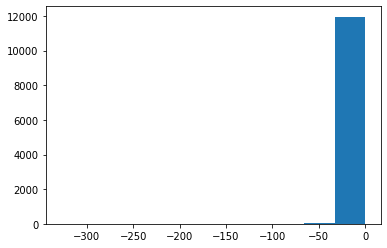

In [6]:
#Calculating the speed difference at points
track_df['lat'] = track_df['geometry'].apply(lambda coord: coord.y)
track_df['lng'] = track_df['geometry'].apply(lambda coord: coord.x)
track_df['speed'] = track_df['GPS Speed.value']
track_df['time_year'] = pd.to_datetime(track_df['time'], format = "%Y-%m")
track_df['year'] = track_df['time_year'].dt.year
track_df['month'] = track_df['time_year'].dt.month

data_to_export = track_df[['id','track.id','time','lat','lng','speed','year','month']]
speed = data_to_export['speed']

spd_list = []
index = 0
for cal in speed:
    currspd = cal
    if index > 0:
        diff = currspd - prvspd
        spd_list.append(diff)
    else:
        spd_list.append(0)
    prvspd = currspd
    index += 1


data_to_export['spddiff']= spd_list
spdneg = data_to_export[data_to_export['spddiff']<0]

plt.hist(spdneg['spddiff'])
            
data_to_export

In [7]:
#mean reduction on speed on track
np.mean(spdneg['spddiff'])

-4.159518325725712

In [8]:
#making a function to color based on speed difference
def colors(array):
    col = []
    for value in array:
        if value < 0 and value > -5:
            col.append('#C2FF00')
        elif value < -5 and value > -20:
            col.append('green')
        else:
            col.append('red')
    return col

In [9]:
cols = colors(spdneg['spddiff'])
#cols

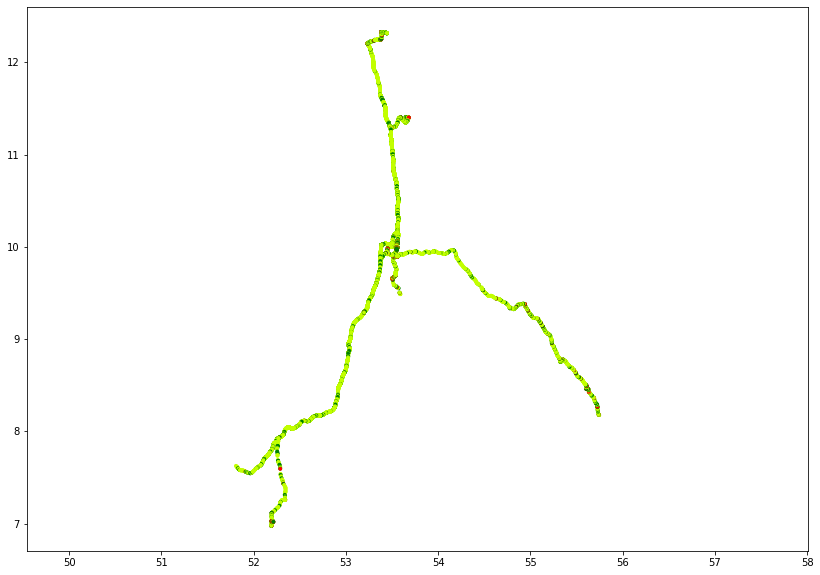

In [10]:
#plotting the tracks based on the reduction in speed
f,axxarr = plt.subplots(1, figsize = (14,10))
#x = np.arange(0,10,1)    
axxarr.scatter(spdneg['lat'], spdneg['lng'], c=cols, cmap='Accent', s=15, lw=0)

plt.axis('equal')
#axxarr.grid(True)
plt.show()

In [11]:
#choosing a single track
#some_track_id = data_to_export['track.id'].unique()[0]
#some_data = data_to_export[data_to_export['track.id'] == some_track_id]
#some_data = some_data[some_data['spddiff'] < 0]
neg_data = data_to_export[data_to_export['spddiff'] < 0]
neg_data

,id,track.id,time,lat,lng,speed,year,month,spddiff
1,5cdcea6d44ea85030283f9e1,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:49,51.807855,7.626002,130.448702,2019,4,-4.457852
4,5cdcea6d44ea85030283f9e4,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:04,51.812016,7.621639,132.869762,2019,4,-0.568984
7,5cdcea6d44ea85030283f9e7,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:19,51.816179,7.616924,137.473462,2019,4,-1.024269
8,5cdcea6d44ea85030283f9e8,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:24,51.817553,7.615308,137.375204,2019,4,-0.098259
9,5cdcea6d44ea85030283f9e9,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:29,51.818925,7.613679,135.989828,2019,4,-1.385375
...,...,...,...,...,...,...,...,...,...
1123,53f20f74e4b0d0547747de57,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:39,53.195092,9.287005,71.100000,2014,6,-26.100000
1124,53f20f74e4b0d0547747de59,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:45,53.194573,9.286022,45.900000,2014,6,-25.200000
1125,53f20f74e4b0d0547747de5b,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:51,53.194776,9.285114,39.600000,2014,6,-6.300000
1128,53f20f74e4b0d0547747de61,53f20f6ee4b0d0547747d58f,2014-06-08T16:06:09,53.196214,9.286828,31.500000,2014,6,-16.200000


In [12]:
##identify first record in each track and adding a default value of 0
tracks_id = (neg_data['id'].groupby(neg_data['track.id']).nth(0)).tolist()
neg_data['spddiff'][neg_data['id'].isin(tracks_id)] = 0

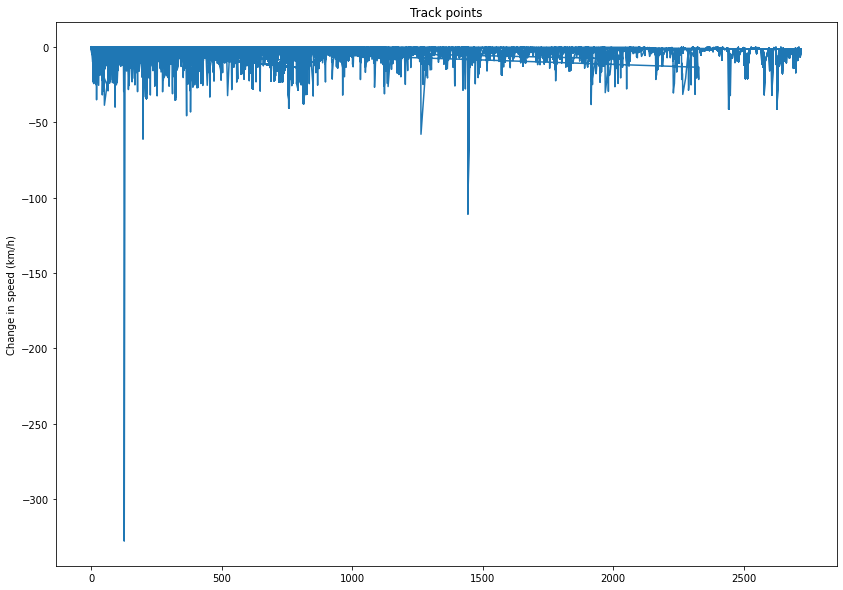

In [13]:
#plotting the change in speed
#plt.plot(some_data['spddiff'].plot(figsize= (10, 8)))
ax = neg_data['spddiff'].plot(figsize= (14, 10))
ax.set_title("Track points")
ax.set_ylabel("Change in speed (km/h)")
ax        

In [14]:
cols_some = colors(neg_data['spddiff'])
print(len(cols_some))
cols_some.pop()
len(cols_some)

12005


12004

In [15]:
#plotting points on a map
lats = list(neg_data['lat'])
lngs = list(neg_data['lng'])
speed = list(neg_data['spddiff']) 
speedactual = list(neg_data['speed'])
avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)
def popfn(a,b):
    return('Speed Difference is: '+ str(round(a, 2))+ 'Km/h'+'\n Actual speed is:' + str(round(b, 2))+'Km/h')

m = folium.Map(location=[avg_lat, avg_lngs], tiles = 'cartodbpositron', zoom_start=8)
for lat, lng , col, pop,pop1 in zip(lats,lngs, cols_some, speed, speedactual ):
    folium.CircleMarker([lat, lng], color= col , radius=2.0, popup = popfn(pop, pop1)).add_to(m)
m.save('SpeedReductionHamburg.html')

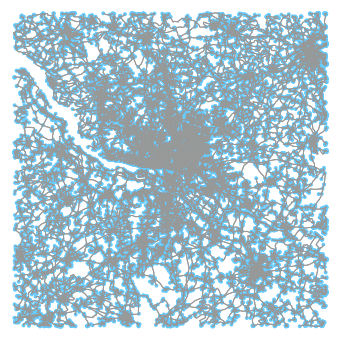

(<Figure size 726.521x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a38b0c510>)

In [16]:
#downloading road netwrok from osmnx
G = ox.graph_from_point((53.54, 10.00), dist=50000, network_type='drive')
ox.plot_graph(G)
#G.to_csv('hamburgosm.csv')
#ox.save_graph_shapefile(G)

In [17]:
#exploring the data frame
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.columns

Index(['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'length',
       'geometry', 'maxspeed', 'lanes', 'ref', 'bridge', 'junction', 'access',
       'width', 'tunnel', 'service', 'est_width'],
      dtype='object')

In [18]:
edges['geometry'].dtype

In [19]:
edges['geometry']

0         LINESTRING (9.67039 53.52337, 9.67026 53.52336...
1         LINESTRING (9.67039 53.52337, 9.67105 53.52315...
2         LINESTRING (9.67039 53.52337, 9.67048 53.52346...
3         LINESTRING (10.22896 53.95189, 10.22842 53.951...
4         LINESTRING (10.22896 53.95189, 10.22964 53.951...
                                ...                        
216058    LINESTRING (9.67222 53.52279, 9.67241 53.52270...
216059    LINESTRING (9.67222 53.52279, 9.67253 53.52316...
216060    LINESTRING (9.67152 53.52297, 9.67113 53.52310...
216061    LINESTRING (9.67152 53.52297, 9.67174 53.52294...
216062    LINESTRING (9.67152 53.52297, 9.67227 53.52385...
Name: geometry, Length: 216063, dtype: geometry

In [20]:
edges['maxspeed'].mean

<bound method Series.mean of 0         NaN
1         NaN
2         NaN
3         NaN
4          30
         ... 
216058    NaN
216059    NaN
216060    NaN
216061    NaN
216062    NaN
Name: maxspeed, Length: 216063, dtype: object>

In [21]:
print(edges['maxspeed'].value_counts())

30                              78992
50                              49567
70                               2655
100                              2620
[30, 50]                         1674
                                ...  
[50, 20, 70]                        1
[80, 60, 70]                        1
[120, signals]                      1
[80, 120, none]                     1
[80, 50, 120, 30, 100, none]        1
Name: maxspeed, Length: 152, dtype: int64


In [22]:
print(edges['highway'].value_counts())

residential                                   129752
tertiary                                       21045
secondary                                      20516
unclassified                                   16074
living_street                                  14252
primary                                         8059
motorway_link                                   1386
[unclassified, residential]                      849
[living_street, residential]                     822
[residential, unclassified]                      737
motorway                                         529
trunk_link                                       515
primary_link                                     483
secondary_link                                   292
trunk                                            288
tertiary_link                                    191
road                                              62
rest_area                                         50
[tertiary, residential]                       

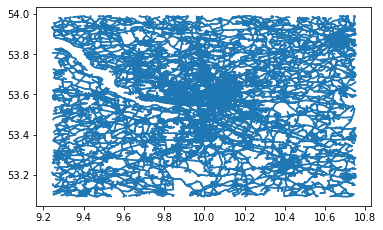

In [23]:
edges.plot()

In [24]:
edges.head()

,u,v,key,osmid,name,highway,oneway,length,geometry,maxspeed,lanes,ref,bridge,junction,access,width,tunnel,service,est_width
0,275251200,275251201,0,25258883,Glosterstraße,residential,False,39.780,"LINESTRING (9.67039 53.52337, 9.67026 53.52336...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,275251200,275251199,0,25258883,Glosterstraße,residential,False,87.301,"LINESTRING (9.67039 53.52337, 9.67105 53.52315...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,275251200,601508668,0,25258891,Glosterstraße,residential,False,54.662,"LINESTRING (9.67039 53.52337, 9.67048 53.52346...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,114294785,114294813,0,12541941,Schwalbenweg,residential,False,140.181,"LINESTRING (10.22896 53.95189, 10.22842 53.951...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,114294785,114294789,0,18959076,Alte Landstraße,residential,False,132.630,"LINESTRING (10.22896 53.95189, 10.22964 53.951...",30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
prjedge = edges.to_crs('EPSG:25832')
prjedge['geometry'] = prjedge.geometry.buffer(5)
prjedge.head()

,u,v,key,osmid,name,highway,oneway,length,geometry,maxspeed,lanes,ref,bridge,junction,access,width,tunnel,service,est_width
0,275251200,275251201,0,25258883,Glosterstraße,residential,False,39.780,"POLYGON ((544435.797 5930697.037, 544435.266 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,275251200,275251199,0,25258883,Glosterstraße,residential,False,87.301,"POLYGON ((544490.405 5930683.219, 544490.779 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,275251200,601508668,0,25258891,Glosterstraße,residential,False,54.662,"POLYGON ((544444.851 5930714.519, 544448.735 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,114294785,114294813,0,12541941,Schwalbenweg,residential,False,140.181,"POLYGON ((580619.713 5978777.261, 580614.338 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,114294785,114294789,0,18959076,Alte Landstraße,residential,False,132.630,"POLYGON ((580696.793 5978841.757, 580696.834 5...",30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
some_trk = gpd.GeoDataFrame(
    neg_data, geometry=gpd.points_from_xy(neg_data.lng, neg_data.lat),crs="EPSG:4326")
#some_trk.crs = "EPSG:4326"
some_trk_tr = some_trk.to_crs('EPSG:25832')
some_trk_tr

,id,track.id,time,lat,lng,speed,year,month,spddiff,geometry
1,5cdcea6d44ea85030283f9e1,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:49,51.807855,7.626002,130.448702,2019,4,0.000000,POINT (405273.087 5740560.439)
4,5cdcea6d44ea85030283f9e4,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:04,51.812016,7.621639,132.869762,2019,4,-0.568984,POINT (404981.069 5741028.881)
7,5cdcea6d44ea85030283f9e7,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:19,51.816179,7.616924,137.473462,2019,4,-1.024269,POINT (404664.817 5741498.007)
8,5cdcea6d44ea85030283f9e8,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:24,51.817553,7.615308,137.375204,2019,4,-0.098259,POINT (404556.337 5741652.922)
9,5cdcea6d44ea85030283f9e9,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:29,51.818925,7.613679,135.989828,2019,4,-1.385375,POINT (404446.968 5741807.576)
...,...,...,...,...,...,...,...,...,...,...
1123,53f20f74e4b0d0547747de57,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:39,53.195092,9.287005,71.100000,2014,6,-26.100000,POINT (519174.046 5894011.716)
1124,53f20f74e4b0d0547747de59,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:45,53.194573,9.286022,45.900000,2014,6,-25.200000,POINT (519108.629 5893953.671)
1125,53f20f74e4b0d0547747de5b,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:51,53.194776,9.285114,39.600000,2014,6,-6.300000,POINT (519047.843 5893976.078)
1128,53f20f74e4b0d0547747de61,53f20f6ee4b0d0547747d58f,2014-06-08T16:06:09,53.196214,9.286828,31.500000,2014,6,-16.200000,POINT (519161.720 5894136.506)


In [27]:
join = gpd.sjoin(some_trk_tr, prjedge, op='intersects')
len(join)
#join.to_csv('table.csv')

3912

In [28]:
#join['maxspeed'].value_counts()

In [29]:
#speeds = []
def getMin(inp):
    min = 10000
    for i in inp:
        if i < min:
            min = i
    return min
        
speed_lst = []
for m in join['maxspeed']:
     #print(m,type(m))
    if (type(m) ==str and len(m) <= 3):
        speed_lst.append(int(m))
    elif type(m) == list:
        conv = []
        for n in m:
            try:
                conv.append(int(n))
            except ValueError:
                conv.append(130)
        speed_lst.append(getMin(conv))        
        
    else:
        speed_lst.append(130)
            
print(speed_lst)   

[130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,

In [30]:
join['spdlimit'] = speed_lst
df = join[['track.id', 'lat', 'lng', 'speed', 'spddiff', 'geometry', 'spdlimit','year', 'month']]
df

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year,month
1437,5cdcea6d44ea85030283f9dd,53.194387,9.286511,126.168509,-0.850732,POINT (519141.345 5893933.126),130,2019,4
1438,5cdcea6d44ea85030283f9dd,53.195467,9.288158,124.246488,-1.922021,POINT (519250.890 5894053.716),130,2019,4
1441,5cdcea6d44ea85030283f9dd,53.198920,9.293395,124.437444,-1.399528,POINT (519599.204 5894439.246),130,2019,4
1443,5cdcea6d44ea85030283f9dd,53.201220,9.296888,122.281555,-2.873144,POINT (519831.456 5894696.071),130,2019,4
1444,5cdcea6d44ea85030283f9dd,53.202338,9.298588,121.596220,-0.685336,POINT (519944.507 5894820.979),130,2019,4
...,...,...,...,...,...,...,...,...,...
877,53f20f6ee4b0d0547747d58f,53.384716,10.019206,60.300000,-1.800000,POINT (567788.744 5915552.382),80,2014,6
895,53f20f6ee4b0d0547747d58f,53.380285,9.977422,120.600000,-2.700000,POINT (565016.437 5915020.530),130,2014,6
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,156.600000,-2.700000,POINT (522886.272 5898124.050),70,2014,6
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,156.600000,-2.700000,POINT (522886.272 5898124.050),70,2014,6


In [31]:
df['ovrspd'] = df['speed']-df['spdlimit']
df[df['ovrspd'] > 5]

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year,month,ovrspd
1459,5cdcea6d44ea85030283f9dd,53.221227,9.323362,140.294373,-4.828542,POINT (521589.828 5896929.496),130,2019,4,10.294373
1460,5cdcea6d44ea85030283f9dd,53.222648,9.325195,139.521638,-0.772736,POINT (521711.507 5897088.081),130,2019,4,9.521638
1463,5cdcea6d44ea85030283f9dd,53.226624,9.330965,140.197310,-1.416241,POINT (522094.685 5897532.192),130,2019,4,10.197310
1464,5cdcea6d44ea85030283f9dd,53.227847,9.332905,138.850595,-1.346715,POINT (522223.541 5897668.874),130,2019,4,8.850595
387,575d0172e4b0a69192a77d65,53.193851,9.285571,175.879186,-1.420802,POINT (519078.775 5893873.250),130,2016,5,45.879186
...,...,...,...,...,...,...,...,...,...,...
869,53f20f6ee4b0d0547747d58f,53.393676,10.023701,98.100000,-3.600000,POINT (568073.375 5916553.412),80,2014,6,18.100000
870,53f20f6ee4b0d0547747d58f,53.392304,10.023017,92.700000,-5.400000,POINT (568030.077 5916400.129),80,2014,6,12.700000
872,53f20f6ee4b0d0547747d58f,53.389436,10.021769,93.600000,-3.600000,POINT (567951.698 5916079.860),80,2014,6,13.600000
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,156.600000,-2.700000,POINT (522886.272 5898124.050),70,2014,6,86.600000


In [32]:
df.to_crs('EPSG:4326')

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year,month,ovrspd
1437,5cdcea6d44ea85030283f9dd,53.194387,9.286511,126.168509,-0.850732,POINT (9.28651 53.19439),130,2019,4,-3.831491
1438,5cdcea6d44ea85030283f9dd,53.195467,9.288158,124.246488,-1.922021,POINT (9.28816 53.19547),130,2019,4,-5.753512
1441,5cdcea6d44ea85030283f9dd,53.198920,9.293395,124.437444,-1.399528,POINT (9.29339 53.19892),130,2019,4,-5.562556
1443,5cdcea6d44ea85030283f9dd,53.201220,9.296888,122.281555,-2.873144,POINT (9.29689 53.20122),130,2019,4,-7.718445
1444,5cdcea6d44ea85030283f9dd,53.202338,9.298588,121.596220,-0.685336,POINT (9.29859 53.20234),130,2019,4,-8.403780
...,...,...,...,...,...,...,...,...,...,...
877,53f20f6ee4b0d0547747d58f,53.384716,10.019206,60.300000,-1.800000,POINT (10.01921 53.38472),80,2014,6,-19.700000
895,53f20f6ee4b0d0547747d58f,53.380285,9.977422,120.600000,-2.700000,POINT (9.97742 53.38028),130,2014,6,-9.400000
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,156.600000,-2.700000,POINT (9.34286 53.23191),70,2014,6,86.600000
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,156.600000,-2.700000,POINT (9.34286 53.23191),70,2014,6,86.600000


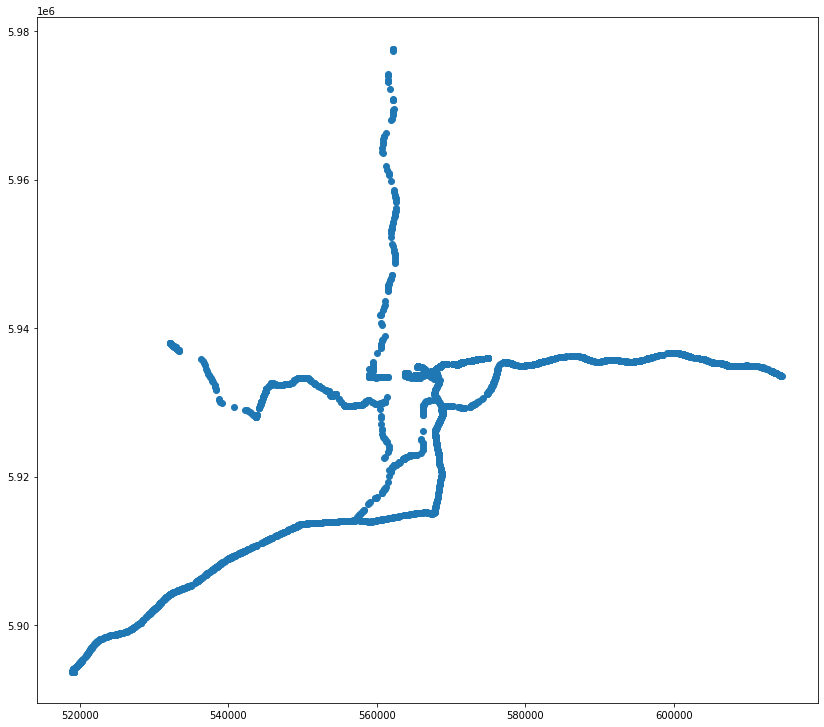

In [33]:
df.plot(figsize = (14,14))

In [34]:
acc = pd.read_csv('HamburgAccidents.csv', usecols=['UJAHR','UMONAT','USTUNDE', 'UWOCHENTAG', 'UKATEGORIE','XGCSWGS84', 'YGCSWGS84'])
acc

,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,XGCSWGS84,YGCSWGS84
0,2018,5,6,4,3,10.026012,53.551961
1,2018,1,7,3,3,10.040709,53.552636
2,2018,1,18,3,3,10.026115,53.553726
3,2018,1,20,5,3,10.040840,53.552596
4,2018,1,15,4,3,10.040660,53.554326
...,...,...,...,...,...,...,...
7171,2018,9,16,2,3,9.794175,53.515091
7172,2018,9,15,3,2,9.816248,53.513303
7173,2018,4,15,4,3,9.850459,53.508057
7174,2018,5,16,2,3,9.841206,53.511960


In [35]:
gdf = gpd.GeoDataFrame(
    acc, geometry=gpd.points_from_xy(acc.XGCSWGS84, acc.YGCSWGS84),crs="EPSG:4326")
gdfproj = gdf.to_crs('EPSG:25832')
gdfproj

,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,XGCSWGS84,YGCSWGS84,geometry
0,2018,5,6,4,3,10.026012,53.551961,POINT (567973.647 5934164.074)
1,2018,1,7,3,3,10.040709,53.552636,POINT (568946.190 5934253.255)
2,2018,1,18,3,3,10.026115,53.553726,POINT (567977.615 5934360.529)
3,2018,1,20,5,3,10.040840,53.552596,POINT (568954.953 5934248.949)
4,2018,1,15,4,3,10.040660,53.554326,POINT (568940.176 5934441.291)
...,...,...,...,...,...,...,...,...
7171,2018,9,16,2,3,9.794175,53.515091,POINT (552660.450 5929866.040)
7172,2018,9,15,3,2,9.816248,53.513303,POINT (554126.294 5929683.740)
7173,2018,4,15,4,3,9.850459,53.508057,POINT (556401.759 5929126.643)
7174,2018,5,16,2,3,9.841206,53.511960,POINT (555783.005 5929553.508)


In [36]:
gdf_cat = gdf.groupby(['YGCSWGS84','XGCSWGS84'])[['UKATEGORIE']].mean().reset_index()
gdf_cat.head()

,YGCSWGS84,XGCSWGS84,UKATEGORIE
0,53.400165,10.175214,3
1,53.400588,10.168204,2
2,53.402485,10.203734,3
3,53.405731,10.176968,3
4,53.405804,10.181413,2


In [37]:
def clr(array):
    col = []
    for value in array:
        if value > 0: 
            col.append('red')
        else:
            col.append('#C2FF00')
    return col

In [38]:
inputCRS = CRS.from_epsg(4326)
outputCRS = CRS.from_epsg(25832)
transformer = Transformer.from_crs(inputCRS, outputCRS)
def project(a,b):
    return transformer.transform(a, b)

In [39]:
def getisOrd(data, value = 'value', threshold = 50, lat = 'lat', lng = 'lng'):
    coords = [project(row[lat], row[lng]) for index, row in data.iterrows()]
    w = pysal.weights.DistanceBand(coords, threshold)         #w = pysal.weights.DistanceBand(coords, threshold)
    #getisOrdGlobal = esda.getisord.G(data_speed['time_sec'], w)
    getisOrdLocal = esda.getisord.G_Local(data[value], w, transform='B')
    getisOrdLocal.Zs

    data['z_score'] = getisOrdLocal.Zs
    data['p_value'] = getisOrdLocal.p_norm

    return data

In [40]:
def pltcolor(p_value, z_score, confidence):
    cols=[]
    size=[]
    for p, z in zip(p_value, z_score):
        if p < confidence:
            if z > 0:
                cols.append('Black')        #hotspot color
                size.append(3)
            else:
                cols.append('blue')       #coldspot color
                size.append(1)
        else:
            cols.append('grey')           #others
            size.append(0.5)
    return cols , size

In [41]:
def map(m, data, value = 'value', style = 'hotspots', lat = 'lat', lng = 'lng', p_field = 'p_value', z_field = 'z_score', col ='#f09205'):
    data = data[data[p_field] < 0.05]
    lats = data[lat]
    lngs = data[lng]

    avg_lat = sum(lats) / len(lats)
    avg_lngs = sum(lngs) / len(lngs)

    latlngs = []
    if style == 'hotspots':
        #z-value
        z = data[z_field]
        p = data[p_field]
        color, sizes = pltcolor(p, z, 0.05)
        value = data[value]
        for lat,lng,c,v, s in zip(lats, lngs, color, value, sizes):
            folium.CircleMarker([lat,lng], color = c, radius =s, fill = c).add_to(m)
            latlngs.append([lat,lng])
    else:
        color = [col]*len(data)
        for lat,lng,c,s in zip(lats, lngs, color, sizes):
            folium.CircleMarker([lat,lng], color = c, radius =s, fill = c).add_to(m)
            latlngs.append([lat,lng])

    m.fit_bounds(latlngs)

In [42]:
lats = list(df['lat'])
lngs = list(df['lng'])
speed = list(df['ovrspd']) 
spdlmt = list(df['spdlimit'])
def poplt(a,b):
    return('Speed limit is: '+ str(a) +'Km/h' +'\n above limit by:' + str(round(b, 2))+ 'Km/h')

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)
ovrspdclr = clr(df['ovrspd'])
m = folium.Map(location=[avg_lat, avg_lngs], tiles = 'cartodbpositron', zoom_start=12)
for lat, lng , col, pop, pop1 in zip(lats,lngs, ovrspdclr, spdlmt, speed):
    folium.CircleMarker([lat, lng], color= col , radius=2.0, popup = poplt(pop, pop1)).add_to(m)
getisacc = getisOrd(gdf_cat, value='UKATEGORIE', threshold=150, lat='YGCSWGS84', lng= 'XGCSWGS84')
map(m, getisacc, value = 'UKATEGORIE', style ='hotspots', lat='YGCSWGS84', lng= 'XGCSWGS84')
m.save('Hotspot&OverspeedPoints.html')

/opt/anaconda3/lib/python3.7/site-packages/pysal/weights/weights.py:189: UserWarning: There are 1010 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/opt/anaconda3/lib/python3.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 20, 21, 22, 26, 30, 31, 32, 33, 34, 39, 41, 44, 46, 47, 48, 51, 52, 53, 55, 56, 57, 58, 59, 64, 67, 68, 70, 73, 74, 75, 76, 77, 78, 79, 84, 85, 90, 91, 92, 94, 96, 98, 103, 105, 107, 108, 114, 115, 117, 118, 130, 133, 134, 136, 137, 139, 142, 152, 162, 163, 165, 166, 174, 175, 179, 182, 183, 185, 186, 194, 197, 201, 228, 241, 251, 252, 256, 257, 261, 262, 284, 288, 291, 292, 293, 304, 308, 311, 312, 317, 321, 327, 337, 345, 361, 370, 372, 379, 388, 391, 392, 395, 396, 399, 405, 444, 463, 476, 489, 506, 507, 508, 509, 513, 519, 520, 523, 525, 529, 530, 531, 532, 536, 537, 538, 539, 540, 541, 545, 546, 547, 560, 562, 569, 575, 576, 585, 588, 589, 590, 593,

In [43]:
acc_cd = gdf.to_crs('EPSG:25832')

In [44]:
acc_cd['geometry'] = acc_cd.geometry.buffer(10)
#gdf.head()

In [45]:
acc_cd

,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,XGCSWGS84,YGCSWGS84,geometry
0,2018,5,6,4,3,10.026012,53.551961,"POLYGON ((567983.647 5934164.074, 567983.599 5..."
1,2018,1,7,3,3,10.040709,53.552636,"POLYGON ((568956.190 5934253.255, 568956.142 5..."
2,2018,1,18,3,3,10.026115,53.553726,"POLYGON ((567987.615 5934360.529, 567987.567 5..."
3,2018,1,20,5,3,10.040840,53.552596,"POLYGON ((568964.953 5934248.949, 568964.905 5..."
4,2018,1,15,4,3,10.040660,53.554326,"POLYGON ((568950.176 5934441.291, 568950.128 5..."
...,...,...,...,...,...,...,...,...
7171,2018,9,16,2,3,9.794175,53.515091,"POLYGON ((552670.450 5929866.040, 552670.402 5..."
7172,2018,9,15,3,2,9.816248,53.513303,"POLYGON ((554136.294 5929683.740, 554136.246 5..."
7173,2018,4,15,4,3,9.850459,53.508057,"POLYGON ((556411.759 5929126.643, 556411.711 5..."
7174,2018,5,16,2,3,9.841206,53.511960,"POLYGON ((555793.005 5929553.508, 555792.957 5..."


In [46]:
le_point = gpd.sjoin(df, acc_cd,op='intersects')
len(le_point)

135

In [47]:
len(le_point['ovrspd'])

135

In [89]:
ovrspd_acc = le_point[le_point['ovrspd']>0]
#ovrspd_acc.to_crs('EPSG:4326')
#ovrspd_acc
ovrspd_acc

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year,month,ovrspd,index_right,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,XGCSWGS84,YGCSWGS84
685,575d0172e4b0a69192a77d65,53.470252,10.024018,129.683181,-1.666021,POINT (567972.159 5925072.365),120,2016,5,9.683181,508,2018,5,16,5,3,10.024043,53.470178
706,575d0172e4b0a69192a77d65,53.496442,10.036173,106.171439,-0.028556,POINT (568736.592 5927997.550),100,2016,5,6.171439,501,2018,8,11,7,3,10.036243,53.496510
708,575d0172e4b0a69192a77d65,53.498800,10.038081,101.665211,-2.784876,POINT (568859.345 5928261.730),100,2016,5,1.665211,502,2018,6,11,6,3,10.038119,53.498857
1890,5cdcea6d44ea85030283f9dd,53.527231,10.022765,72.823170,-7.147506,POINT (567798.040 5931409.914),60,2019,4,12.823170,693,2018,7,11,5,3,10.022781,53.527224
284,5c50dd0744ea850302ea1950,53.523531,9.812451,56.088760,-0.345958,POINT (553861.529 5930818.636),50,2018,12,6.088760,1875,2018,5,6,6,3,9.812577,53.523573
284,5c50dd0744ea850302ea1950,53.523531,9.812451,56.088760,-0.345958,POINT (553861.529 5930818.636),50,2018,12,6.088760,1875,2018,5,6,6,3,9.812577,53.523573
19,575d0129e4b0a69192a77bc4,53.556967,9.997083,54.899999,-0.900001,POINT (566049.350 5934693.744),50,2016,5,4.899999,1428,2018,11,17,1,3,9.997035,53.556959
19,575d0129e4b0a69192a77bc4,53.556967,9.997083,54.899999,-0.900001,POINT (566049.350 5934693.744),50,2016,5,4.899999,1428,2018,11,17,1,3,9.997035,53.556959
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.600000,POINT (566116.935 5934666.815),50,2016,5,1.299999,1216,2018,7,9,2,3,9.997956,53.556698
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.600000,POINT (566116.935 5934666.815),50,2016,5,1.299999,1216,2018,7,9,2,3,9.997956,53.556698


In [90]:
ovrspd_acc.rename(
    columns={
        "index_right": "index_right_1"
    },
    inplace=True
)

In [60]:
pubs = pd.read_csv('pubshamburg.csv', usecols=['venue.name','venue.location.address','venue.location.lat', 'venue.location.lng'])
pubs['lat'] = pubs['venue.location.lat']
pubs['lng'] = pubs['venue.location.lng']
pubs['name'] = pubs['venue.name']
pubs['address'] = pubs['venue.location.address']
pubs= pubs.drop(columns=['venue.location.lat','venue.location.address','venue.location.lng','venue.name'])
pubs

,lat,lng,name,address
0,53.542455,9.998270,Boilerman Bar,Osakaallee 12
1,53.577759,9.951489,Mr. Ape,Stellinger Weg 9
2,53.550125,9.994436,Le Lion,Rathausstr. 3
3,53.553192,9.958023,Clockers,Paul-Roosen-Str. 27
4,53.558708,9.964224,Zoë II / Sofabar,Neuer Pferdemarkt 17
...,...,...,...,...
95,53.555596,9.962647,The Walrus,Wohlwillstr. 47
96,53.551189,9.957895,STANDARD,NaN
97,53.563091,9.965371,Frank und Frei,Schanzenstr. 93
98,53.585366,9.981245,Cafe & Bar Celona,Lenhartzstr. 1-5


In [91]:
pubsdf = gpd.GeoDataFrame(
    pubs, geometry=gpd.points_from_xy(pubs.lng, pubs.lat),crs="EPSG:4326")
pubsdfproj = pubsdf.to_crs('EPSG:25832')
pubsdfproj['geometry'] = pubsdfproj.geometry.buffer(500)
pubsdfproj

,lat,lng,name,address,geometry
0,53.542455,9.998270,Boilerman Bar,Osakaallee 12,"POLYGON ((566650.627 5933080.409, 566648.219 5..."
1,53.577759,9.951489,Mr. Ape,Stellinger Weg 9,"POLYGON ((563498.228 5936965.522, 563495.821 5..."
2,53.550125,9.994436,Le Lion,Rathausstr. 3,"POLYGON ((566384.636 5933930.168, 566382.228 5..."
3,53.553192,9.958023,Clockers,Paul-Roosen-Str. 27,"POLYGON ((563967.628 5934238.307, 563965.220 5..."
4,53.558708,9.964224,Zoë II / Sofabar,Neuer Pferdemarkt 17,"POLYGON ((564370.098 5934857.514, 564367.691 5..."
...,...,...,...,...,...
95,53.555596,9.962647,The Walrus,Wohlwillstr. 47,"POLYGON ((564270.336 5934509.875, 564267.928 5..."
96,53.551189,9.957895,STANDARD,NaN,"POLYGON ((563962.153 5934015.353, 563959.745 5..."
97,53.563091,9.965371,Frank und Frei,Schanzenstr. 93,"POLYGON ((564439.475 5935346.128, 564437.068 5..."
98,53.585366,9.981245,Cafe & Bar Celona,Lenhartzstr. 1-5,"POLYGON ((565456.681 5937838.505, 565454.273 5..."


In [92]:
pubsacc = gpd.sjoin(ovrspd_acc,pubsdfproj, op='intersects')
pubsacc

,track.id,lat_left,lng_left,speed,spddiff,geometry,spdlimit,year,month,ovrspd,...,USTUNDE,UWOCHENTAG,UKATEGORIE,XGCSWGS84,YGCSWGS84,index_right,lat_right,lng_right,name,address
19,575d0129e4b0a69192a77bc4,53.556967,9.997083,54.899999,-0.900001,POINT (566049.350 5934693.744),50,2016,5,4.899999,...,17,1,3,9.997035,53.556959,25,53.554233,9.998983,CIU',Ballindamm 14/15
19,575d0129e4b0a69192a77bc4,53.556967,9.997083,54.899999,-0.900001,POINT (566049.350 5934693.744),50,2016,5,4.899999,...,17,1,3,9.997035,53.556959,25,53.554233,9.998983,CIU',Ballindamm 14/15
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.600000,POINT (566116.935 5934666.815),50,2016,5,1.299999,...,9,2,3,9.997956,53.556698,25,53.554233,9.998983,CIU',Ballindamm 14/15
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.600000,POINT (566116.935 5934666.815),50,2016,5,1.299999,...,9,2,3,9.997956,53.556698,25,53.554233,9.998983,CIU',Ballindamm 14/15
19,575d0129e4b0a69192a77bc4,53.556967,9.997083,54.899999,-0.900001,POINT (566049.350 5934693.744),50,2016,5,4.899999,...,17,1,3,9.997035,53.556959,13,53.555494,9.991845,The Bar,Hotel Vier Jahreszeiten
19,575d0129e4b0a69192a77bc4,53.556967,9.997083,54.899999,-0.900001,POINT (566049.350 5934693.744),50,2016,5,4.899999,...,17,1,3,9.997035,53.556959,13,53.555494,9.991845,The Bar,Hotel Vier Jahreszeiten
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.600000,POINT (566116.935 5934666.815),50,2016,5,1.299999,...,9,2,3,9.997956,53.556698,13,53.555494,9.991845,The Bar,Hotel Vier Jahreszeiten
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.600000,POINT (566116.935 5934666.815),50,2016,5,1.299999,...,9,2,3,9.997956,53.556698,13,53.555494,9.991845,The Bar,Hotel Vier Jahreszeiten
19,575d0129e4b0a69192a77bc4,53.556967,9.997083,54.899999,-0.900001,POINT (566049.350 5934693.744),50,2016,5,4.899999,...,17,1,3,9.997035,53.556959,62,53.557710,9.990562,Klimperkiste,Esplanade 18
19,575d0129e4b0a69192a77bc4,53.556967,9.997083,54.899999,-0.900001,POINT (566049.350 5934693.744),50,2016,5,4.899999,...,17,1,3,9.997035,53.556959,62,53.557710,9.990562,Klimperkiste,Esplanade 18


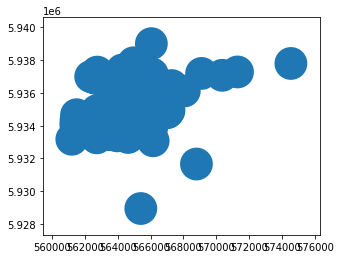

In [81]:
pubsdfproj.plot()

In [84]:
lats1 = list(pubsacc['lat_left'])
lngs1 = list(pubsacc['lng_left'])
lt = list(pubs['lat'])
ln = list(pubs['lng'])
avg_lat = sum(lats1) / len(lats1)
avg_lngs = sum(lngs1) / len(lngs1)

m = folium.Map(location=[avg_lat, avg_lngs], tiles = 'cartodbpositron', zoom_start=10)
for lat, lng in zip(lats1,lngs1):
    folium.CircleMarker([lat, lng], radius=1).add_to(m)
for lat, lng in zip(lt,ln):
    folium.CircleMarker([lat, lng], radius=3, color = 'red').add_to(m)
m.save('testham.html')

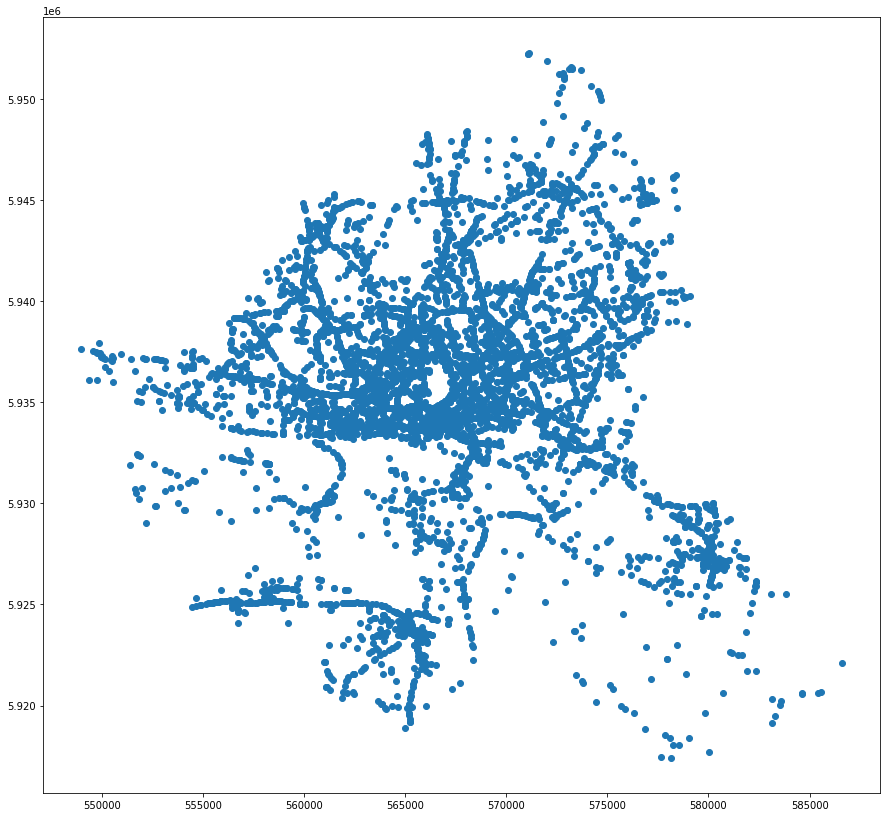

In [54]:
gdfproj.plot(figsize=(15,15))

In [55]:
pubsacc = gpd.sjoin(testproj,pubsdfproj, op='intersects')
pubsacc

,track.id,lat_left,lng_left,speed,spddiff,geometry,spdlimit,year,month,ovrspd,...,USTUNDE,UWOCHENTAG,UKATEGORIE,XGCSWGS84,YGCSWGS84,index_right,lat_right,lng_right,name,address
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.6,"POLYGON ((5923568.051 1540847.487, 5923565.643...",50,2016,5,1.299999,...,9,2,3,9.997956,53.556698,25,53.554233,9.998983,CIU',Ballindamm 14/15
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.6,"POLYGON ((5923568.051 1540847.487, 5923565.643...",50,2016,5,1.299999,...,9,2,3,9.997956,53.556698,25,53.554233,9.998983,CIU',Ballindamm 14/15


In [56]:
pubsacc.crs='EPSG:4326'
pubsacc

,track.id,lat_left,lng_left,speed,spddiff,geometry,spdlimit,year,month,ovrspd,...,USTUNDE,UWOCHENTAG,UKATEGORIE,XGCSWGS84,YGCSWGS84,index_right,lat_right,lng_right,name,address
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.6,"POLYGON ((5923568.051 1540847.487, 5923565.643...",50,2016,5,1.299999,...,9,2,3,9.997956,53.556698,25,53.554233,9.998983,CIU',Ballindamm 14/15
20,575d0129e4b0a69192a77bc4,53.556716,9.998097,51.299999,-3.6,"POLYGON ((5923568.051 1540847.487, 5923565.643...",50,2016,5,1.299999,...,9,2,3,9.997956,53.556698,25,53.554233,9.998983,CIU',Ballindamm 14/15
